In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from statistics import mode
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
# SET50 (unrealize)
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'GLOBAL', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

# remove (low data) : TPIPP WHA SPRC SAWAD PSH MTLS IVL GPSC EA CBG BPP BEAUTY PTTGC

In [3]:
def load_stock_data(symbol, year_start, year_end):
    stock_data = []
    with open('./SET50/' + symbol + '.BK.csv', 'r') as csv_file:
        file_data = csv.reader(csv_file, delimiter=',')
        file_data = list(file_data)[1:]
        temp_value = 0
        for row in file_data:
            if row[2] is '':
                continue
            elif int(row[0][0:4]) >= year_start and int(row[0][0:4]) <= year_end:
                temp = (float(row[1]) + float(row[4]))/2.0
                if temp_value != 0:
                    unrealize = (temp - temp_value)/ temp_value
                else:
                    unrealize = 0
                unrealize = ["{0:.4f}".format(unrealize)]
                stock_data.append(unrealize)
                temp_value = temp
                
    return stock_data

def mean_square_error(actual, predict):
    length = len(actual)
    sums_error = 0.0
    for i, j in zip(actual, predict):
        sums_error += (i - j)**2
    
    return sums_error / length

def findNewXTest(x_test, predict):
    for (index, element) in enumerate(x_test[0]):
        for i in range(len(element)):
            if i == 0:
                continue
            elif i < 29:
                element[i - 1] = element[i]
            else:
                element[i - 1] = element[i]
                element[i] = "{0:.4f}".format(predict[index])
    return x_test

In [4]:
stock_datas = [ load_stock_data(x, 2007, 2017) for x in SET50 ]

min_count = len(stock_datas[0])

for index, element in enumerate(stock_datas):
    if len(element) < min_count:
        min_count = len(element)

min_count

2043

In [5]:
def create_model(conv_count, fully_count):
    i = 0
    model = Sequential()
    while(i <= conv_count):
        if i == 0:
            model.add(Conv2D(256, (7, 1), input_shape=(len(stock_datas), 30, 1), padding='same'))
        else:
            model.add(Conv2D(128, (3, 1)))
            
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 1), data_format= "channels_last"))
        i += 1
        
    i = 0
    model.add(Flatten())
    
    while(i <= fully_count):
        if i == fully_count:
            model.add(Dropout(0.2))
            model.add(Dense(len(stock_datas)))
        else:
            model.add(Dense(256))  
            model.add(Activation('relu'))
        i += 1
    
    return model

In [6]:
size = 15
models = [create_model(int(_/5), _%5) for _ in range(size)]
# (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) ... (2, 5)
# first for conv, second for fully connected

In [7]:
lr = 0.95
decay = 1e-6

In [8]:
optimizer = SGD(lr=lr, decay=decay)
for model in models:
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae'])

In [9]:
rounds = min_count - 30
train_index = int(rounds * 0.85)
validate_index = train_index + int(rounds * 0.05)

In [10]:
data = []
count = 0
index = 0
while index < rounds:
    temp = [i[index : index + 30] for i in stock_datas]
    data.append(temp)
    index += 1
    
x = np.asarray(data)
x_train = x[0: train_index].astype('float32')
x_validate = x[train_index: validate_index].astype('float32')
x_test = x[validate_index: validate_index + 1].astype('float32')

print(x_train.shape, x_validate.shape, x_test.shape)

(1711, 37, 30, 1) (100, 37, 30, 1) (1, 37, 30, 1)


In [11]:
target = []
index = 0
while index < rounds:
    temp = [stock_datas[i][index + 30][0] for i in range(len(stock_datas))]
    target.append(temp)
    index += 1
    
y = np.asarray(target)
y_train = y[0: train_index].astype('float32')
y_validate = y[train_index: validate_index].astype('float32')
y_test = y[validate_index: rounds].astype('float32')

print(y_train.shape, y_validate.shape, y_test.shape)

(1711, 37) (100, 37) (202, 37)


In [12]:
epochs = 100

for (index, model) in enumerate(models):
    print(index)
    model.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, shuffle = True, batch_size = 100, verbose= 1)
    

0
Train on 1711 samples, validate on 100 samples
Epoch 1/100
1711/1711 [==============================] - 8s 5ms/step - loss: 7.8237e-04 - acc: 0.0380 - mean_absolute_error: 0.0140 - val_loss: 1.4752e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0089
Epoch 2/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.7807e-04 - acc: 0.0403 - mean_absolute_error: 0.0139 - val_loss: 1.4816e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 3/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.7377e-04 - acc: 0.0409 - mean_absolute_error: 0.0139 - val_loss: 1.4784e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 4/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.7178e-04 - acc: 0.0444 - mean_absolute_error: 0.0139 - val_loss: 1.4760e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 5/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6840e-04 - acc: 0.0421 - mean_absolute_error

1711/1711 [==============================] - 4s 2ms/step - loss: 7.0898e-04 - acc: 0.0544 - mean_absolute_error: 0.0137 - val_loss: 1.4598e-04 - val_acc: 0.0500 - val_mean_absolute_error: 0.0088
Epoch 41/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.0813e-04 - acc: 0.0620 - mean_absolute_error: 0.0137 - val_loss: 1.4564e-04 - val_acc: 0.0700 - val_mean_absolute_error: 0.0088
Epoch 42/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.0512e-04 - acc: 0.0608 - mean_absolute_error: 0.0137 - val_loss: 1.5240e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0090
Epoch 43/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.0575e-04 - acc: 0.0491 - mean_absolute_error: 0.0137 - val_loss: 1.4751e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 44/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.0309e-04 - acc: 0.0532 - mean_absolute_error: 0.0137 - val_loss: 1.4616e-04 - val_acc: 0.0200 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 6.6975e-04 - acc: 0.0690 - mean_absolute_error: 0.0136 - val_loss: 1.4551e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0088
Epoch 80/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.6924e-04 - acc: 0.0625 - mean_absolute_error: 0.0136 - val_loss: 1.4507e-04 - val_acc: 0.0700 - val_mean_absolute_error: 0.0088
Epoch 81/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.6906e-04 - acc: 0.0590 - mean_absolute_error: 0.0136 - val_loss: 1.4468e-04 - val_acc: 0.0800 - val_mean_absolute_error: 0.0088
Epoch 82/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.6788e-04 - acc: 0.0567 - mean_absolute_error: 0.0136 - val_loss: 1.4449e-04 - val_acc: 0.1100 - val_mean_absolute_error: 0.0088
Epoch 83/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.6794e-04 - acc: 0.0602 - mean_absolute_error: 0.0136 - val_loss: 1.4619e-04 - val_acc: 0.1100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.4422e-04 - acc: 0.0421 - mean_absolute_error: 0.0138 - val_loss: 1.4632e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 19/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4255e-04 - acc: 0.0392 - mean_absolute_error: 0.0138 - val_loss: 1.4666e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0088
Epoch 20/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4186e-04 - acc: 0.0473 - mean_absolute_error: 0.0138 - val_loss: 1.4682e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 21/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.3887e-04 - acc: 0.0462 - mean_absolute_error: 0.0138 - val_loss: 1.4638e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0088
Epoch 22/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.3847e-04 - acc: 0.0368 - mean_absolute_error: 0.0138 - val_loss: 1.4584e-04 - val_acc: 0.0400 - v

1711/1711 [==============================] - 4s 2ms/step - loss: 7.0025e-04 - acc: 0.0573 - mean_absolute_error: 0.0137 - val_loss: 1.5676e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0092
Epoch 58/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.9769e-04 - acc: 0.0514 - mean_absolute_error: 0.0138 - val_loss: 1.4731e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 59/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.9922e-04 - acc: 0.0508 - mean_absolute_error: 0.0137 - val_loss: 1.4759e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 60/100
1711/1711 [==============================] - 5s 3ms/step - loss: 6.9548e-04 - acc: 0.0473 - mean_absolute_error: 0.0138 - val_loss: 1.4519e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0088
Epoch 61/100
1711/1711 [==============================] - 5s 3ms/step - loss: 6.9670e-04 - acc: 0.0567 - mean_absolute_error: 0.0137 - val_loss: 1.4699e-04 - val_acc: 0.0300 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 6.6742e-04 - acc: 0.0602 - mean_absolute_error: 0.0137 - val_loss: 1.4567e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0088
Epoch 97/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.6552e-04 - acc: 0.0643 - mean_absolute_error: 0.0137 - val_loss: 1.4506e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0088
Epoch 98/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.6873e-04 - acc: 0.0666 - mean_absolute_error: 0.0137 - val_loss: 1.4552e-04 - val_acc: 0.0600 - val_mean_absolute_error: 0.0088
Epoch 99/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.6810e-04 - acc: 0.0520 - mean_absolute_error: 0.0137 - val_loss: 1.4548e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0088
Epoch 100/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.6393e-04 - acc: 0.0672 - mean_absolute_error: 0.0137 - val_loss: 1.4479e-04 - val_acc: 0.0600 - val_

1711/1711 [==============================] - 4s 2ms/step - loss: 7.4463e-04 - acc: 0.0438 - mean_absolute_error: 0.0137 - val_loss: 1.4697e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 36/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4386e-04 - acc: 0.0520 - mean_absolute_error: 0.0137 - val_loss: 1.4542e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0088
Epoch 37/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4326e-04 - acc: 0.0532 - mean_absolute_error: 0.0137 - val_loss: 1.4543e-04 - val_acc: 0.0800 - val_mean_absolute_error: 0.0088
Epoch 38/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4296e-04 - acc: 0.0590 - mean_absolute_error: 0.0137 - val_loss: 1.4533e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0088
Epoch 39/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4173e-04 - acc: 0.0567 - mean_absolute_error: 0.0137 - val_loss: 1.4554e-04 - val_acc: 0.0400 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.2103e-04 - acc: 0.0508 - mean_absolute_error: 0.0137 - val_loss: 1.4545e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 75/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.1827e-04 - acc: 0.0602 - mean_absolute_error: 0.0137 - val_loss: 1.4673e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0089
Epoch 76/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.1861e-04 - acc: 0.0520 - mean_absolute_error: 0.0137 - val_loss: 1.4566e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0088
Epoch 77/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.1795e-04 - acc: 0.0497 - mean_absolute_error: 0.0137 - val_loss: 1.4544e-04 - val_acc: 0.0600 - val_mean_absolute_error: 0.0088
Epoch 78/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.1772e-04 - acc: 0.0573 - mean_absolute_error: 0.0137 - val_loss: 1.4554e-04 - val_acc: 0.0200 - val_m

1711/1711 [==============================] - 5s 3ms/step - loss: 7.6374e-04 - acc: 0.0415 - mean_absolute_error: 0.0137 - val_loss: 1.4632e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 14/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.6322e-04 - acc: 0.0409 - mean_absolute_error: 0.0137 - val_loss: 1.4800e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 15/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.6328e-04 - acc: 0.0438 - mean_absolute_error: 0.0137 - val_loss: 1.4696e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 16/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.6270e-04 - acc: 0.0503 - mean_absolute_error: 0.0137 - val_loss: 1.5534e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0091
Epoch 17/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.6367e-04 - acc: 0.0415 - mean_absolute_error: 0.0138 - val_loss: 1.4774e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 5s 3ms/step - loss: 7.4332e-04 - acc: 0.0438 - mean_absolute_error: 0.0137 - val_loss: 1.4710e-04 - val_acc: 0.0700 - val_mean_absolute_error: 0.0089
Epoch 53/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.4367e-04 - acc: 0.0386 - mean_absolute_error: 0.0137 - val_loss: 1.4635e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0089
Epoch 54/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.4476e-04 - acc: 0.0491 - mean_absolute_error: 0.0137 - val_loss: 1.4506e-04 - val_acc: 0.0500 - val_mean_absolute_error: 0.0088
Epoch 55/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.4390e-04 - acc: 0.0368 - mean_absolute_error: 0.0137 - val_loss: 1.4583e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 56/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.4288e-04 - acc: 0.0380 - mean_absolute_error: 0.0137 - val_loss: 1.4594e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 5s 3ms/step - loss: 7.2529e-04 - acc: 0.0421 - mean_absolute_error: 0.0137 - val_loss: 1.4518e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0088
Epoch 92/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.2569e-04 - acc: 0.0479 - mean_absolute_error: 0.0137 - val_loss: 1.4721e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0088
Epoch 93/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.2602e-04 - acc: 0.0567 - mean_absolute_error: 0.0137 - val_loss: 1.4687e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0089
Epoch 94/100
1711/1711 [==============================] - ETA: 0s - loss: 7.2699e-04 - acc: 0.0512 - mean_absolute_error: 0.013 - 5s 3ms/step - loss: 7.2436e-04 - acc: 0.0508 - mean_absolute_error: 0.0137 - val_loss: 1.4612e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0089
Epoch 95/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.2381e-04 - acc: 0.0409 - 

Epoch 30/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.5981e-04 - acc: 0.0479 - mean_absolute_error: 0.0137 - val_loss: 1.4635e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 31/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.5890e-04 - acc: 0.0444 - mean_absolute_error: 0.0137 - val_loss: 1.4652e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 32/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5934e-04 - acc: 0.0468 - mean_absolute_error: 0.0137 - val_loss: 1.4729e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 33/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.5833e-04 - acc: 0.0491 - mean_absolute_error: 0.0137 - val_loss: 1.4524e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 34/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.5750e-04 - acc: 0.0432 - mean_absolute_error: 0.0137 - val_loss: 1.4602e-04 - val_acc: 0

1711/1711 [==============================] - 4s 3ms/step - loss: 7.5145e-04 - acc: 0.0403 - mean_absolute_error: 0.0138 - val_loss: 1.4799e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 70/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.4710e-04 - acc: 0.0491 - mean_absolute_error: 0.0137 - val_loss: 1.4852e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0089
Epoch 71/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.4544e-04 - acc: 0.0555 - mean_absolute_error: 0.0137 - val_loss: 1.4624e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 72/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.4457e-04 - acc: 0.0362 - mean_absolute_error: 0.0137 - val_loss: 1.4913e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0089
Epoch 73/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.4474e-04 - acc: 0.0479 - mean_absolute_error: 0.0137 - val_loss: 1.4582e-04 - val_acc: 0.0600 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.7035e-04 - acc: 0.0392 - mean_absolute_error: 0.0139 - val_loss: 1.4673e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 9/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.7034e-04 - acc: 0.0380 - mean_absolute_error: 0.0139 - val_loss: 1.4661e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 10/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6891e-04 - acc: 0.0397 - mean_absolute_error: 0.0139 - val_loss: 1.4576e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 11/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6871e-04 - acc: 0.0409 - mean_absolute_error: 0.0139 - val_loss: 1.4622e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 12/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6862e-04 - acc: 0.0409 - mean_absolute_error: 0.0139 - val_loss: 1.4634e-04 - val_acc: 0.0100 - val_me

1711/1711 [==============================] - 4s 2ms/step - loss: 7.4716e-04 - acc: 0.0427 - mean_absolute_error: 0.0138 - val_loss: 1.4703e-04 - val_acc: 0.0600 - val_mean_absolute_error: 0.0089
Epoch 48/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4643e-04 - acc: 0.0427 - mean_absolute_error: 0.0138 - val_loss: 1.4711e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 49/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4651e-04 - acc: 0.0403 - mean_absolute_error: 0.0138 - val_loss: 1.4572e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 50/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4572e-04 - acc: 0.0444 - mean_absolute_error: 0.0138 - val_loss: 1.4609e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0088
Epoch 51/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4508e-04 - acc: 0.0409 - mean_absolute_error: 0.0138 - val_loss: 1.4610e-04 - val_acc: 0.0800 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.2642e-04 - acc: 0.0450 - mean_absolute_error: 0.0138 - val_loss: 1.4564e-04 - val_acc: 0.0500 - val_mean_absolute_error: 0.0088
Epoch 87/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2509e-04 - acc: 0.0485 - mean_absolute_error: 0.0138 - val_loss: 1.4542e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0088
Epoch 88/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2613e-04 - acc: 0.0450 - mean_absolute_error: 0.0138 - val_loss: 1.4538e-04 - val_acc: 0.0800 - val_mean_absolute_error: 0.0088
Epoch 89/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2525e-04 - acc: 0.0450 - mean_absolute_error: 0.0138 - val_loss: 1.4632e-04 - val_acc: 0.0900 - val_mean_absolute_error: 0.0088
Epoch 90/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2353e-04 - acc: 0.0456 - mean_absolute_error: 0.0138 - val_loss: 1.4601e-04 - val_acc: 0.0000e+00 - v

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6082e-04 - acc: 0.0427 - mean_absolute_error: 0.0138 - val_loss: 1.4648e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0088
Epoch 26/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6099e-04 - acc: 0.0444 - mean_absolute_error: 0.0138 - val_loss: 1.4611e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 27/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5852e-04 - acc: 0.0468 - mean_absolute_error: 0.0138 - val_loss: 1.4643e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 28/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5847e-04 - acc: 0.0491 - mean_absolute_error: 0.0138 - val_loss: 1.4522e-04 - val_acc: 0.0600 - val_mean_absolute_error: 0.0088
Epoch 29/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5811e-04 - acc: 0.0479 - mean_absolute_error: 0.0138 - val_loss: 1.4574e-04 - val_acc: 0.0200 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.4613e-04 - acc: 0.0450 - mean_absolute_error: 0.0138 - val_loss: 1.4715e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0089
Epoch 65/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4549e-04 - acc: 0.0450 - mean_absolute_error: 0.0138 - val_loss: 1.4714e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0089
Epoch 66/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4455e-04 - acc: 0.0380 - mean_absolute_error: 0.0138 - val_loss: 1.4613e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 67/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4510e-04 - acc: 0.0526 - mean_absolute_error: 0.0138 - val_loss: 1.4568e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 68/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4504e-04 - acc: 0.0444 - mean_absolute_error: 0.0138 - val_loss: 1.4518e-04 - val_acc: 0.0200 - v

1711/1711 [==============================] - 4s 2ms/step - loss: 7.7005e-04 - acc: 0.0397 - mean_absolute_error: 0.0138 - val_loss: 1.4692e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 4/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6999e-04 - acc: 0.0409 - mean_absolute_error: 0.0138 - val_loss: 1.4675e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 5/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6846e-04 - acc: 0.0421 - mean_absolute_error: 0.0138 - val_loss: 1.5169e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0090
Epoch 6/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6862e-04 - acc: 0.0432 - mean_absolute_error: 0.0138 - val_loss: 1.4565e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0088
Epoch 7/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6821e-04 - acc: 0.0479 - mean_absolute_error: 0.0138 - val_loss: 1.4631e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5511e-04 - acc: 0.0479 - mean_absolute_error: 0.0137 - val_loss: 1.4638e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 43/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5556e-04 - acc: 0.0485 - mean_absolute_error: 0.0137 - val_loss: 1.4692e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 44/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5587e-04 - acc: 0.0485 - mean_absolute_error: 0.0137 - val_loss: 1.4678e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0089
Epoch 45/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5510e-04 - acc: 0.0450 - mean_absolute_error: 0.0137 - val_loss: 1.4722e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 46/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5391e-04 - acc: 0.0479 - mean_absolute_error: 0.0137 - val_loss: 1.4585e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.4602e-04 - acc: 0.0421 - mean_absolute_error: 0.0137 - val_loss: 1.6096e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0093
Epoch 82/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4829e-04 - acc: 0.0427 - mean_absolute_error: 0.0138 - val_loss: 1.4609e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 83/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4583e-04 - acc: 0.0432 - mean_absolute_error: 0.0138 - val_loss: 1.4557e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 84/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4567e-04 - acc: 0.0497 - mean_absolute_error: 0.0137 - val_loss: 1.4470e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0088
Epoch 85/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4425e-04 - acc: 0.0438 - mean_absolute_error: 0.0138 - val_loss: 1.4838e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6275e-04 - acc: 0.0432 - mean_absolute_error: 0.0137 - val_loss: 1.4704e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 21/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6301e-04 - acc: 0.0438 - mean_absolute_error: 0.0137 - val_loss: 1.4644e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 22/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6228e-04 - acc: 0.0427 - mean_absolute_error: 0.0137 - val_loss: 1.4782e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 23/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6228e-04 - acc: 0.0392 - mean_absolute_error: 0.0137 - val_loss: 1.4669e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0088
Epoch 24/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6184e-04 - acc: 0.0444 - mean_absolute_error: 0.0137 - val_loss: 1.4658e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5657e-04 - acc: 0.0403 - mean_absolute_error: 0.0138 - val_loss: 1.4731e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 60/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5408e-04 - acc: 0.0432 - mean_absolute_error: 0.0137 - val_loss: 1.4619e-04 - val_acc: 0.0800 - val_mean_absolute_error: 0.0088
Epoch 61/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5344e-04 - acc: 0.0456 - mean_absolute_error: 0.0137 - val_loss: 1.5262e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0091
Epoch 62/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5434e-04 - acc: 0.0450 - mean_absolute_error: 0.0137 - val_loss: 1.4745e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0089
Epoch 63/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5342e-04 - acc: 0.0462 - mean_absolute_error: 0.0137 - val_loss: 1.4588e-04 - val_acc: 0.0200 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.4379e-04 - acc: 0.0479 - mean_absolute_error: 0.0137 - val_loss: 1.4610e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0088
Epoch 99/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4286e-04 - acc: 0.0456 - mean_absolute_error: 0.0137 - val_loss: 1.4783e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 100/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4369e-04 - acc: 0.0520 - mean_absolute_error: 0.0138 - val_loss: 1.4833e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0089
9
Train on 1711 samples, validate on 100 samples
Epoch 1/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.7101e-04 - acc: 0.0357 - mean_absolute_error: 0.0137 - val_loss: 1.4629e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 2/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6966e-04 - acc: 0.0403 - mean_absolute_error: 0.0137 

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6234e-04 - acc: 0.0438 - mean_absolute_error: 0.0137 - val_loss: 1.4576e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0088
Epoch 38/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6260e-04 - acc: 0.0456 - mean_absolute_error: 0.0137 - val_loss: 1.4622e-04 - val_acc: 0.0500 - val_mean_absolute_error: 0.0088
Epoch 39/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6287e-04 - acc: 0.0462 - mean_absolute_error: 0.0137 - val_loss: 1.4584e-04 - val_acc: 0.0600 - val_mean_absolute_error: 0.0088
Epoch 40/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6233e-04 - acc: 0.0450 - mean_absolute_error: 0.0137 - val_loss: 1.4815e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 41/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6220e-04 - acc: 0.0473 - mean_absolute_error: 0.0137 - val_loss: 1.4570e-04 - val_acc: 0.0200 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5752e-04 - acc: 0.0427 - mean_absolute_error: 0.0137 - val_loss: 1.4633e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0089
Epoch 77/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5732e-04 - acc: 0.0503 - mean_absolute_error: 0.0137 - val_loss: 1.4703e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 78/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5774e-04 - acc: 0.0444 - mean_absolute_error: 0.0137 - val_loss: 1.4583e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 79/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5778e-04 - acc: 0.0450 - mean_absolute_error: 0.0137 - val_loss: 1.5810e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0092
Epoch 80/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5866e-04 - acc: 0.0508 - mean_absolute_error: 0.0138 - val_loss: 1.4610e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.7263e-04 - acc: 0.0380 - mean_absolute_error: 0.0139 - val_loss: 1.4891e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 16/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.7082e-04 - acc: 0.0368 - mean_absolute_error: 0.0138 - val_loss: 1.4658e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 17/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.7031e-04 - acc: 0.0392 - mean_absolute_error: 0.0138 - val_loss: 1.4619e-04 - val_acc: 0.0600 - val_mean_absolute_error: 0.0088
Epoch 18/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.7021e-04 - acc: 0.0438 - mean_absolute_error: 0.0138 - val_loss: 1.4622e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 19/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6969e-04 - acc: 0.0374 - mean_absolute_error: 0.0138 - val_loss: 1.4597e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6156e-04 - acc: 0.0421 - mean_absolute_error: 0.0138 - val_loss: 1.4534e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 55/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6189e-04 - acc: 0.0497 - mean_absolute_error: 0.0138 - val_loss: 1.4563e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 56/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6183e-04 - acc: 0.0427 - mean_absolute_error: 0.0138 - val_loss: 1.4666e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 57/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.6133e-04 - acc: 0.0397 - mean_absolute_error: 0.0138 - val_loss: 1.4711e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 58/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6161e-04 - acc: 0.0421 - mean_absolute_error: 0.0138 - val_loss: 1.4684e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5639e-04 - acc: 0.0427 - mean_absolute_error: 0.0138 - val_loss: 1.4698e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 94/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5492e-04 - acc: 0.0468 - mean_absolute_error: 0.0138 - val_loss: 1.4718e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 95/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5447e-04 - acc: 0.0427 - mean_absolute_error: 0.0138 - val_loss: 1.4628e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0088
Epoch 96/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5441e-04 - acc: 0.0468 - mean_absolute_error: 0.0138 - val_loss: 1.4553e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 97/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5504e-04 - acc: 0.0432 - mean_absolute_error: 0.0138 - val_loss: 1.4612e-04 - val_acc: 0.0100 - v

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6135e-04 - acc: 0.0415 - mean_absolute_error: 0.0138 - val_loss: 1.4671e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 33/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6062e-04 - acc: 0.0456 - mean_absolute_error: 0.0138 - val_loss: 1.4642e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 34/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6085e-04 - acc: 0.0485 - mean_absolute_error: 0.0138 - val_loss: 1.4543e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0088
Epoch 35/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6137e-04 - acc: 0.0497 - mean_absolute_error: 0.0138 - val_loss: 1.4581e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 36/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6050e-04 - acc: 0.0438 - mean_absolute_error: 0.0138 - val_loss: 1.4833e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5506e-04 - acc: 0.0503 - mean_absolute_error: 0.0138 - val_loss: 1.4566e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 72/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5524e-04 - acc: 0.0532 - mean_absolute_error: 0.0138 - val_loss: 1.4577e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0088
Epoch 73/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5466e-04 - acc: 0.0444 - mean_absolute_error: 0.0138 - val_loss: 1.4667e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 74/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5426e-04 - acc: 0.0549 - mean_absolute_error: 0.0138 - val_loss: 1.4691e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 75/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5376e-04 - acc: 0.0456 - mean_absolute_error: 0.0138 - val_loss: 1.4581e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6744e-04 - acc: 0.0403 - mean_absolute_error: 0.0137 - val_loss: 1.4508e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 11/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6712e-04 - acc: 0.0374 - mean_absolute_error: 0.0137 - val_loss: 1.4531e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 12/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6646e-04 - acc: 0.0427 - mean_absolute_error: 0.0137 - val_loss: 1.4642e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 13/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6629e-04 - acc: 0.0403 - mean_absolute_error: 0.0137 - val_loss: 1.4587e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 14/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6693e-04 - acc: 0.0427 - mean_absolute_error: 0.0137 - val_loss: 1.4652e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5967e-04 - acc: 0.0403 - mean_absolute_error: 0.0137 - val_loss: 1.4545e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 50/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5977e-04 - acc: 0.0450 - mean_absolute_error: 0.0137 - val_loss: 1.4622e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 51/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5962e-04 - acc: 0.0479 - mean_absolute_error: 0.0137 - val_loss: 1.4623e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 52/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5961e-04 - acc: 0.0421 - mean_absolute_error: 0.0137 - val_loss: 1.4581e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 53/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5912e-04 - acc: 0.0438 - mean_absolute_error: 0.0137 - val_loss: 1.4552e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5477e-04 - acc: 0.0473 - mean_absolute_error: 0.0137 - val_loss: 1.4615e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 89/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5266e-04 - acc: 0.0450 - mean_absolute_error: 0.0138 - val_loss: 1.4524e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0088
Epoch 90/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5438e-04 - acc: 0.0450 - mean_absolute_error: 0.0137 - val_loss: 1.4530e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 91/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5460e-04 - acc: 0.0432 - mean_absolute_error: 0.0137 - val_loss: 1.4470e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 92/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5386e-04 - acc: 0.0544 - mean_absolute_error: 0.0137 - val_loss: 1.4556e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6323e-04 - acc: 0.0421 - mean_absolute_error: 0.0137 - val_loss: 1.4632e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 28/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6255e-04 - acc: 0.0444 - mean_absolute_error: 0.0137 - val_loss: 1.4518e-04 - val_acc: 0.0600 - val_mean_absolute_error: 0.0088
Epoch 29/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6299e-04 - acc: 0.0456 - mean_absolute_error: 0.0137 - val_loss: 1.4596e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0088
Epoch 30/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6232e-04 - acc: 0.0380 - mean_absolute_error: 0.0137 - val_loss: 1.7027e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0095
Epoch 31/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6603e-04 - acc: 0.0421 - mean_absolute_error: 0.0138 - val_loss: 1.4615e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5771e-04 - acc: 0.0409 - mean_absolute_error: 0.0137 - val_loss: 1.4763e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 67/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5676e-04 - acc: 0.0450 - mean_absolute_error: 0.0137 - val_loss: 1.4466e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0088
Epoch 68/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5744e-04 - acc: 0.0479 - mean_absolute_error: 0.0137 - val_loss: 1.4784e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 69/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5641e-04 - acc: 0.0432 - mean_absolute_error: 0.0137 - val_loss: 1.4758e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 70/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5832e-04 - acc: 0.0415 - mean_absolute_error: 0.0137 - val_loss: 1.4572e-04 - val_acc: 0.0100 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6855e-04 - acc: 0.0403 - mean_absolute_error: 0.0137 - val_loss: 1.4566e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 6/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6812e-04 - acc: 0.0415 - mean_absolute_error: 0.0137 - val_loss: 1.4558e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 7/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6807e-04 - acc: 0.0427 - mean_absolute_error: 0.0137 - val_loss: 1.4597e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 8/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6784e-04 - acc: 0.0438 - mean_absolute_error: 0.0137 - val_loss: 1.4620e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 9/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6715e-04 - acc: 0.0432 - mean_absolute_error: 0.0137 - val_loss: 1.4585e-04 - val_acc: 0.0100 - val_mean_

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6192e-04 - acc: 0.0432 - mean_absolute_error: 0.0137 - val_loss: 1.4544e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 45/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6217e-04 - acc: 0.0421 - mean_absolute_error: 0.0137 - val_loss: 1.4710e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 46/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6177e-04 - acc: 0.0479 - mean_absolute_error: 0.0137 - val_loss: 1.4683e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0088
Epoch 47/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6168e-04 - acc: 0.0409 - mean_absolute_error: 0.0137 - val_loss: 1.4629e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 48/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6126e-04 - acc: 0.0438 - mean_absolute_error: 0.0137 - val_loss: 1.4566e-04 - val_acc: 0.0200 - val_m

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5664e-04 - acc: 0.0479 - mean_absolute_error: 0.0137 - val_loss: 1.4666e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0089
Epoch 84/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5658e-04 - acc: 0.0432 - mean_absolute_error: 0.0137 - val_loss: 1.4613e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0088
Epoch 85/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5643e-04 - acc: 0.0392 - mean_absolute_error: 0.0137 - val_loss: 1.4676e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0089
Epoch 86/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5612e-04 - acc: 0.0497 - mean_absolute_error: 0.0137 - val_loss: 1.4610e-04 - val_acc: 0.0700 - val_mean_absolute_error: 0.0089
Epoch 87/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5578e-04 - acc: 0.0503 - mean_absolute_error: 0.0137 - val_loss: 1.4530e-04 - val_acc: 0.0200 - val_m

In [13]:
errors = [[] for i in range(size)]
predicts = [[] for i in range(size)]
for i in range(size):
    test_data = x_test.copy()
    for (index, element) in enumerate(y_test):
        predict = models[i].predict(test_data, verbose = 0)
        predicts[i].append(predict[0])
        errors[i].append(mean_square_error(element, predict[0]))
        test_data = findNewXTest(test_data, predict[0])

In [14]:
predicts = [np.asarray(predict).astype('float32') for predict in predicts]

In [15]:
def plot_graph(array1, array2, array3, array4):
    plt.figure(figsize=(20,10))
    x_axis = [i for i in range(len(array1))]
    plt.plot(x_axis, array1, 'r')
    plt.plot(x_axis, array2, 'b')
    plt.plot(x_axis, array3, 'g')
    plt.plot(x_axis, array4, 'y')

    plt.show()
    
def get_data_from_nparray(nparray, index):
    return_data = [i[index] for i in nparray]
    return return_data

ADVANC


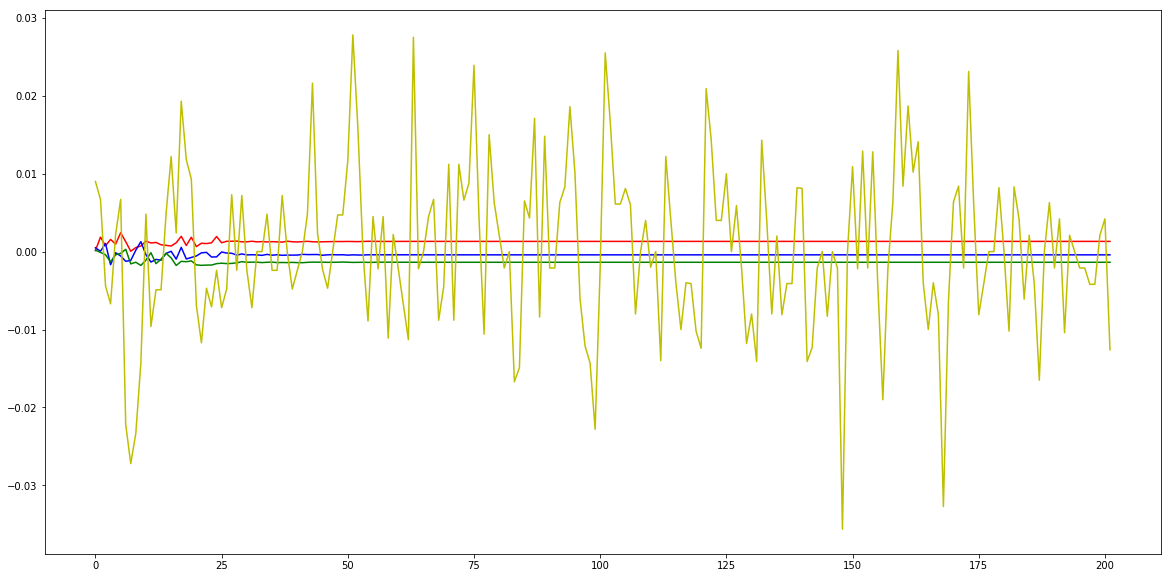

AOT


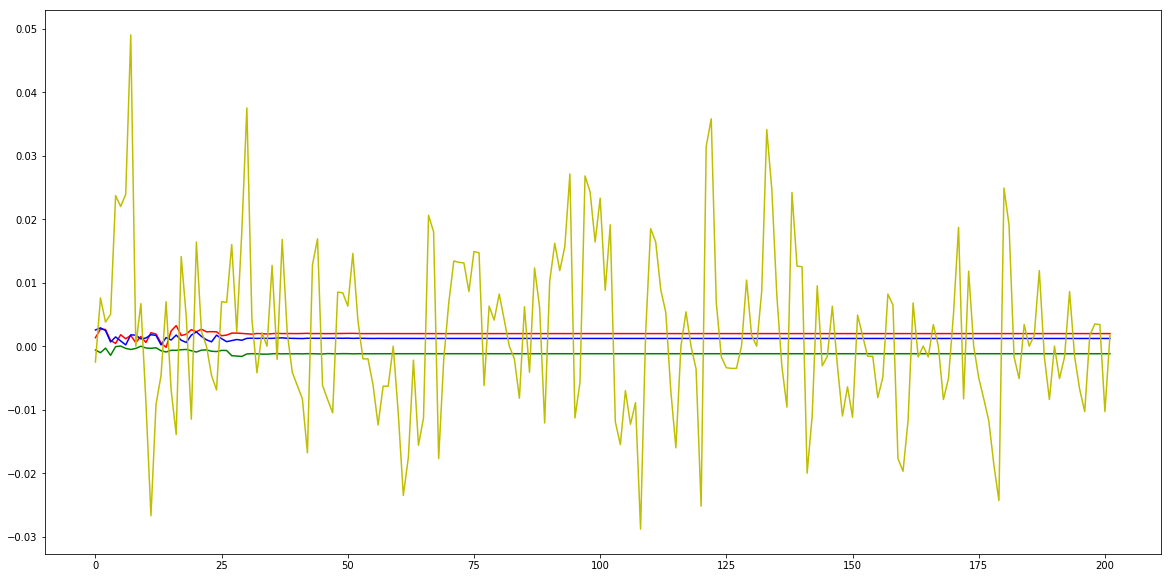

BANPU


BBL


BCP


BDMS


BEM


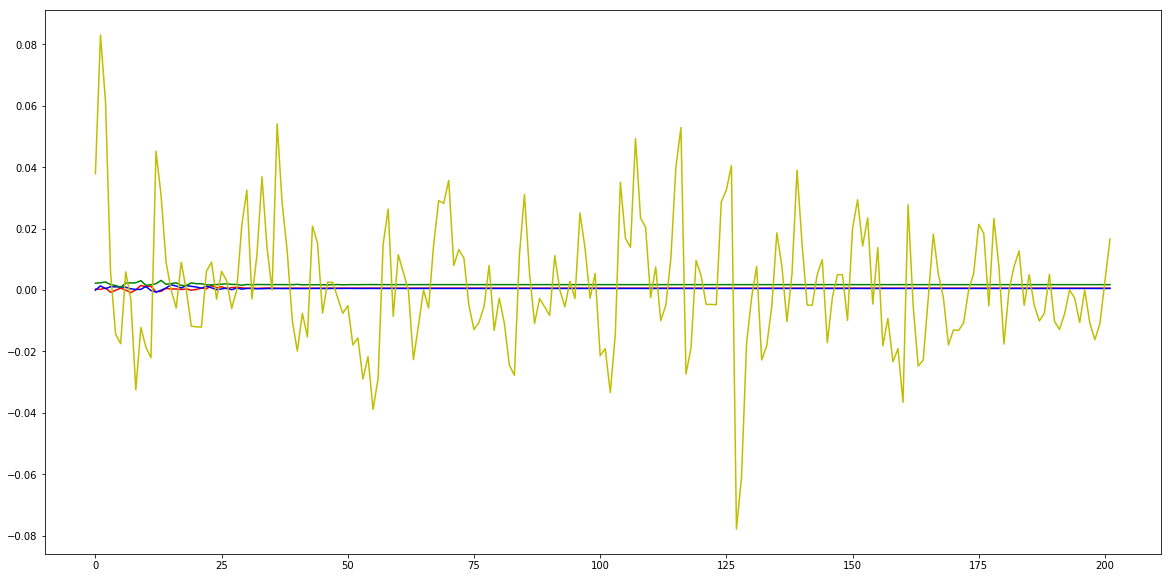

BH


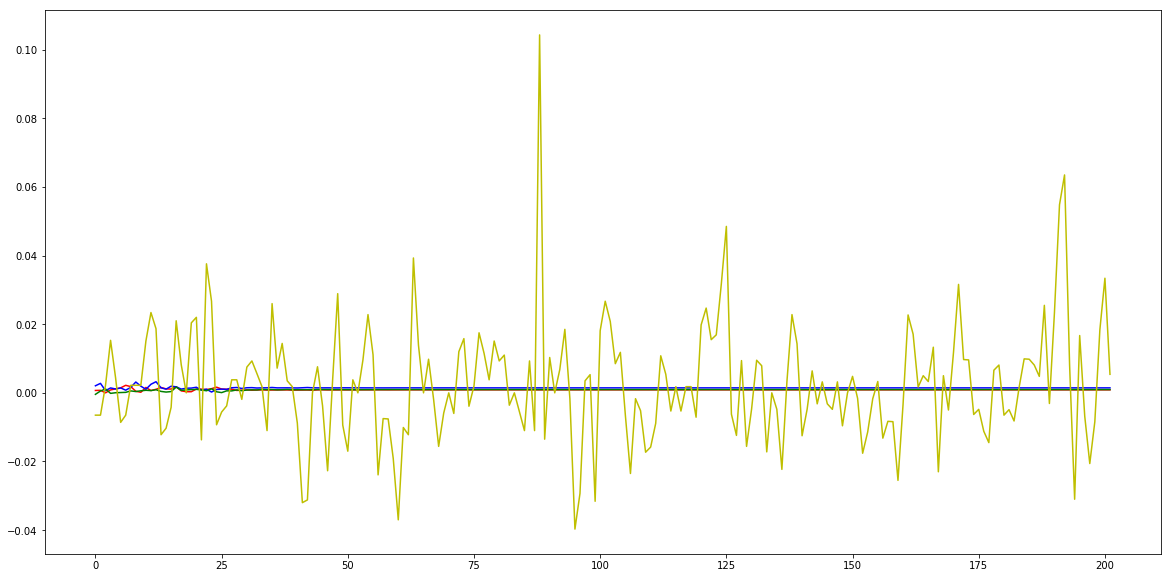

BJC


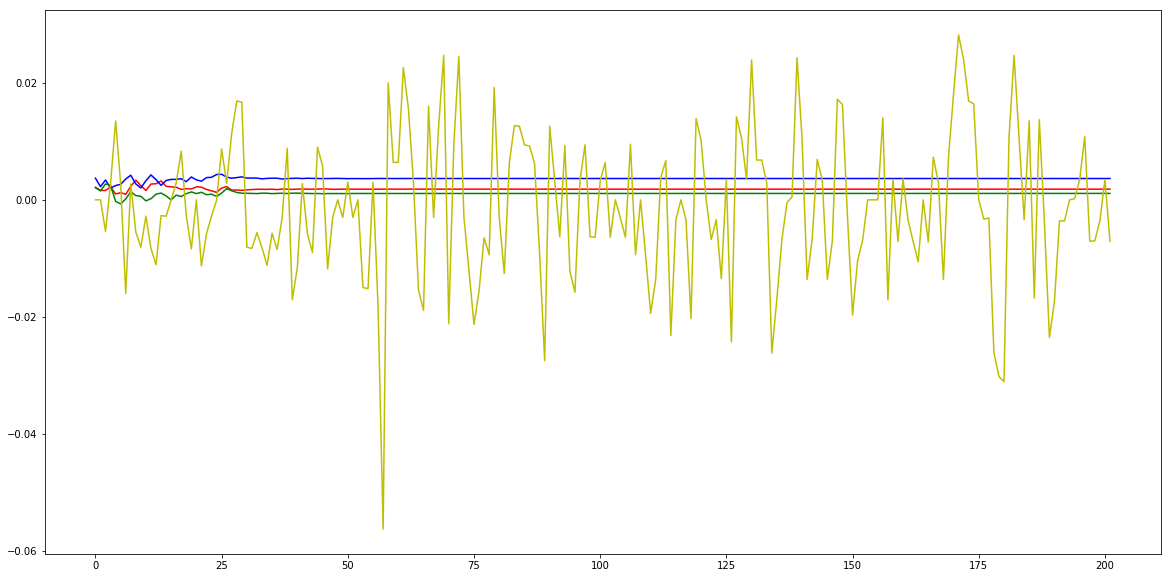

BTS


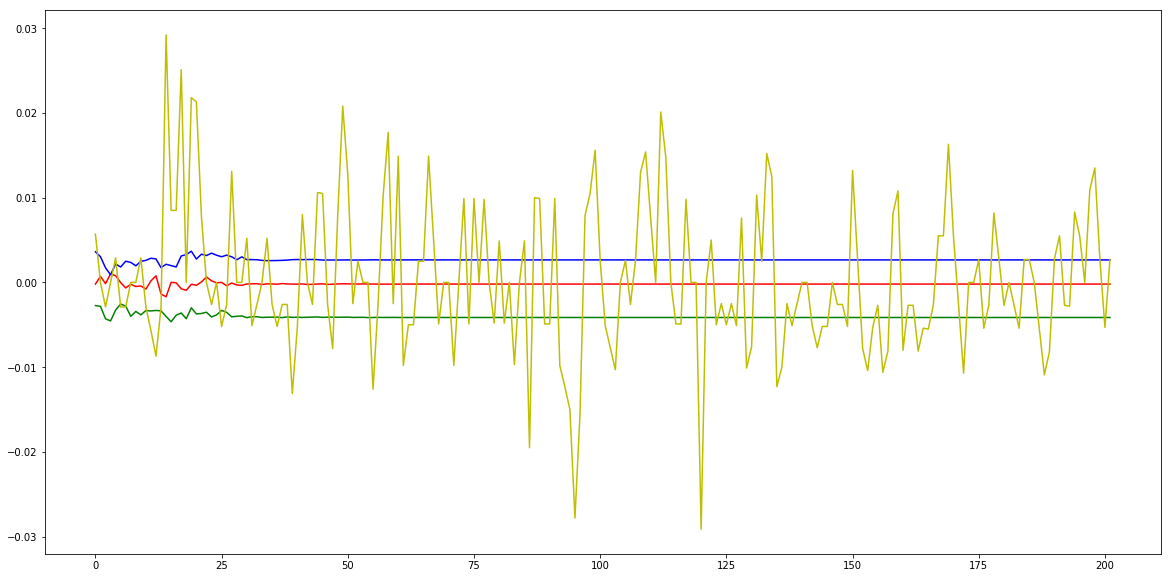

CENTEL


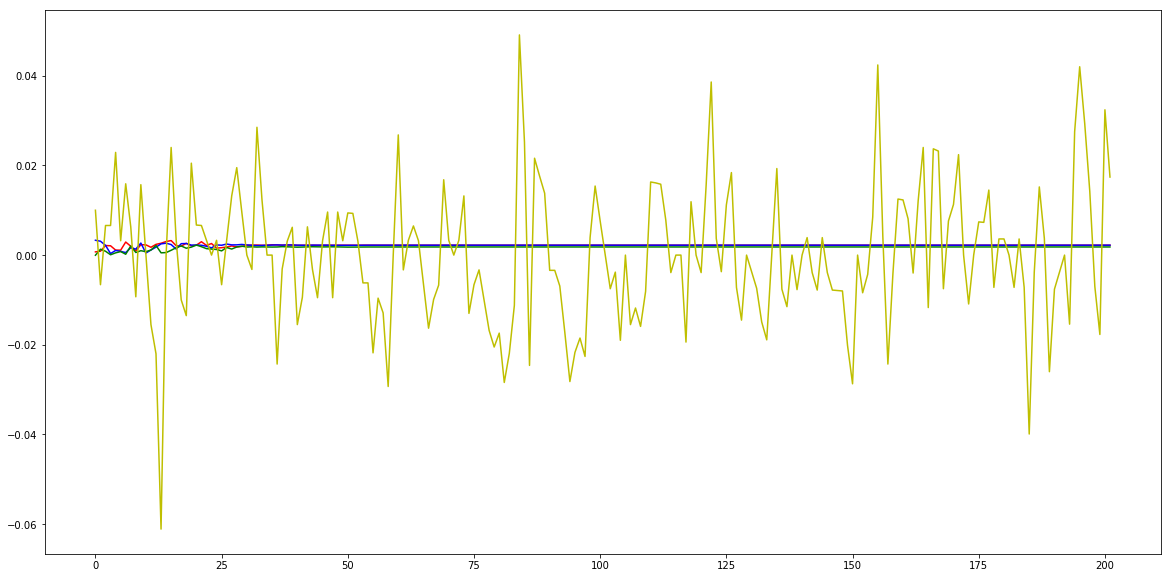

CPALL


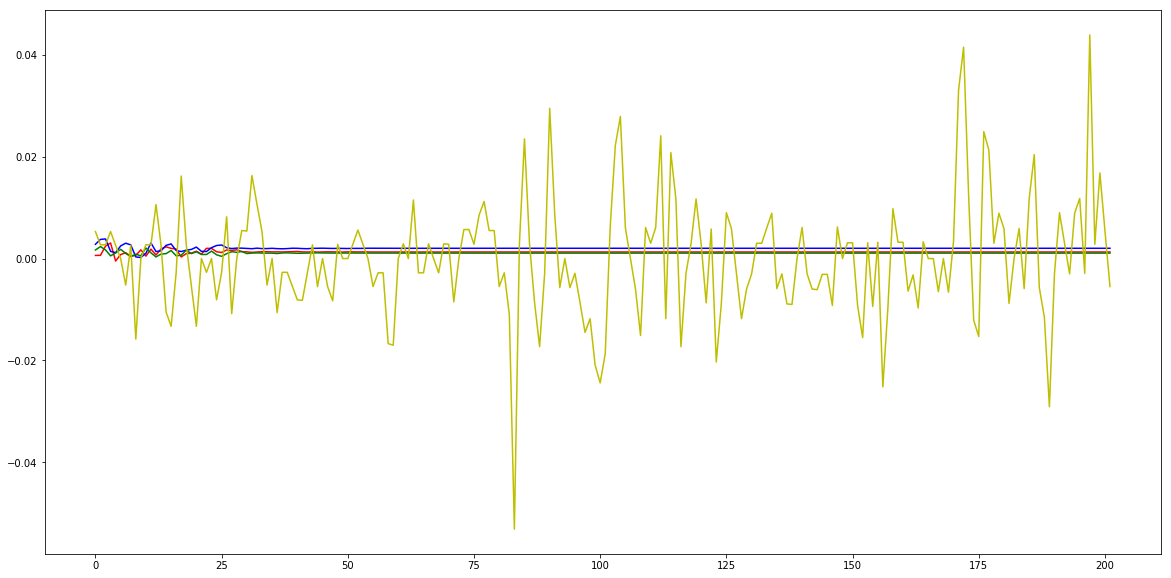

CPF


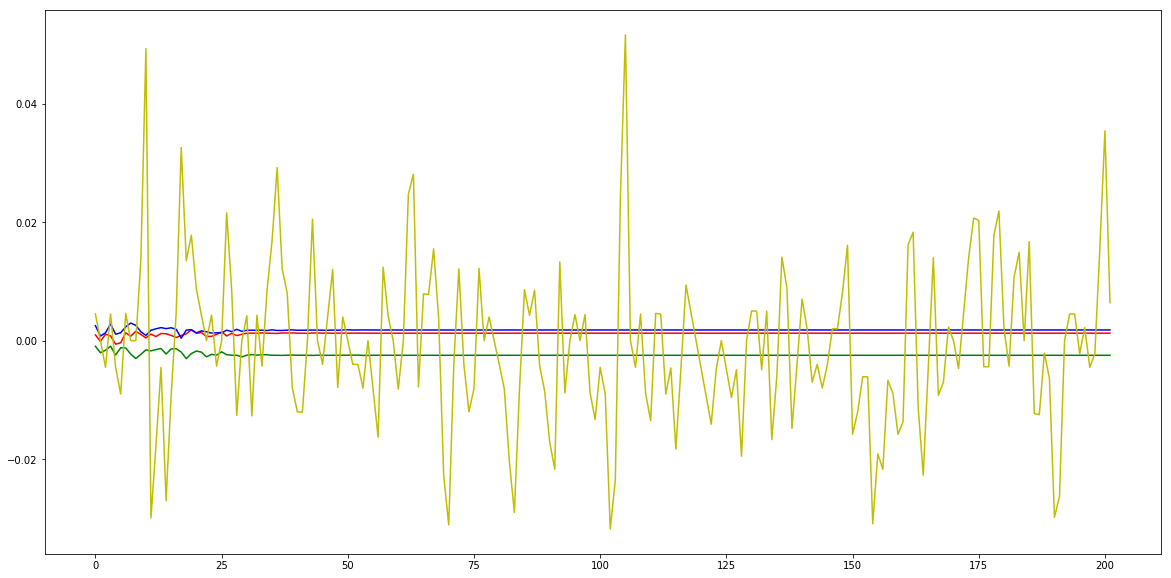

CPN


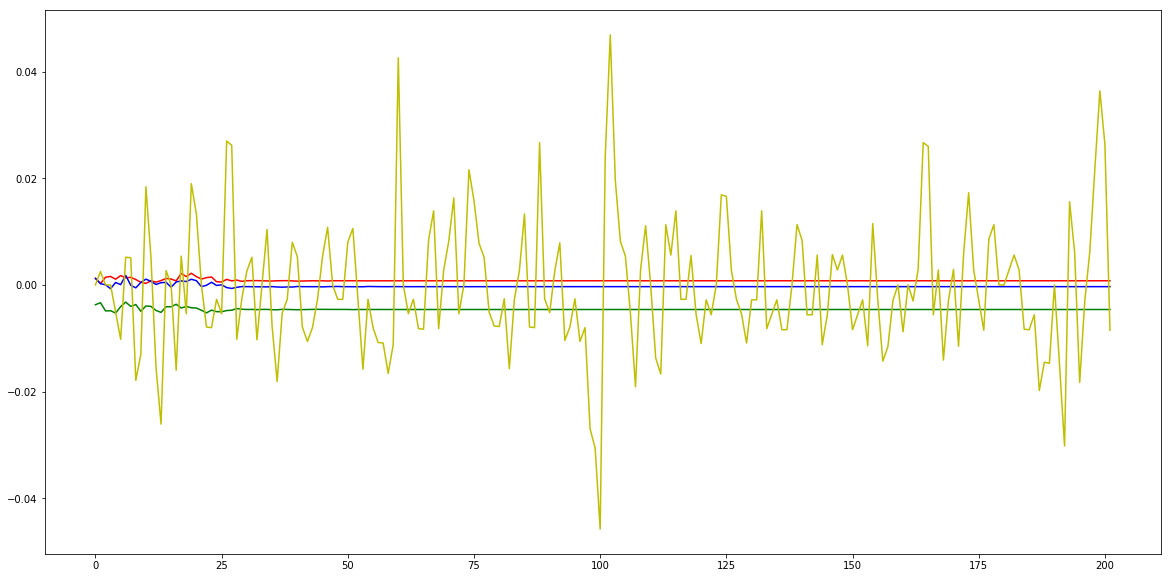

DTAC


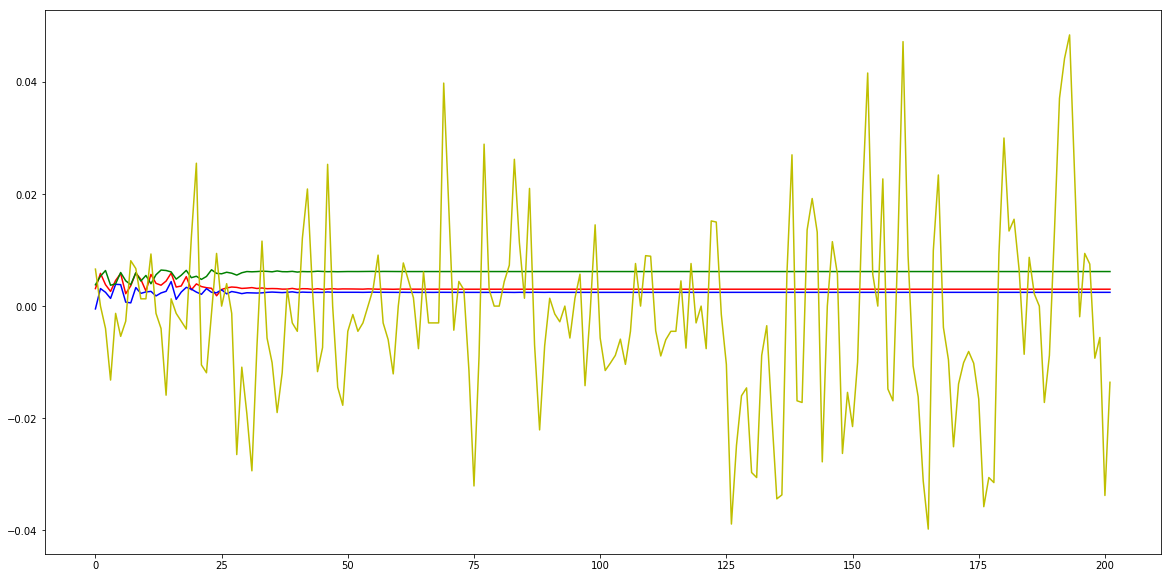

EGCO


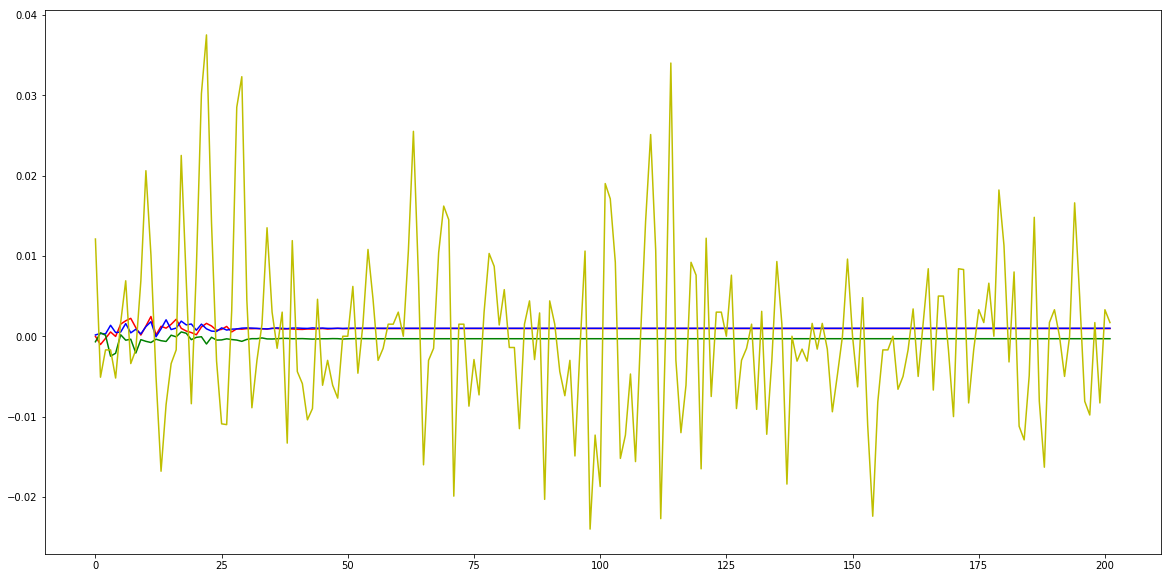

GLOBAL


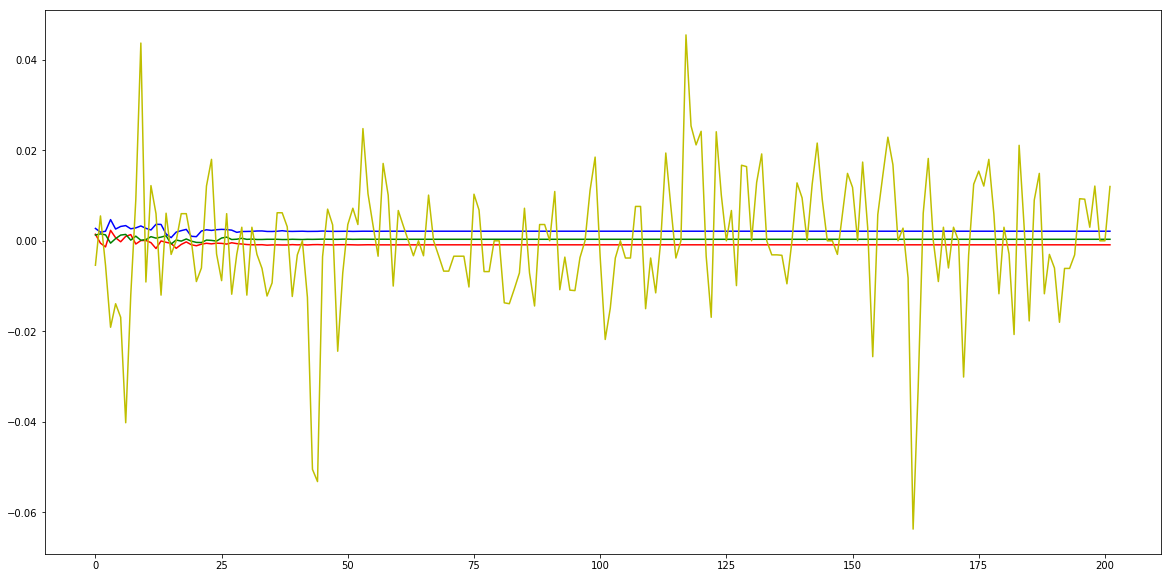

HMPRO


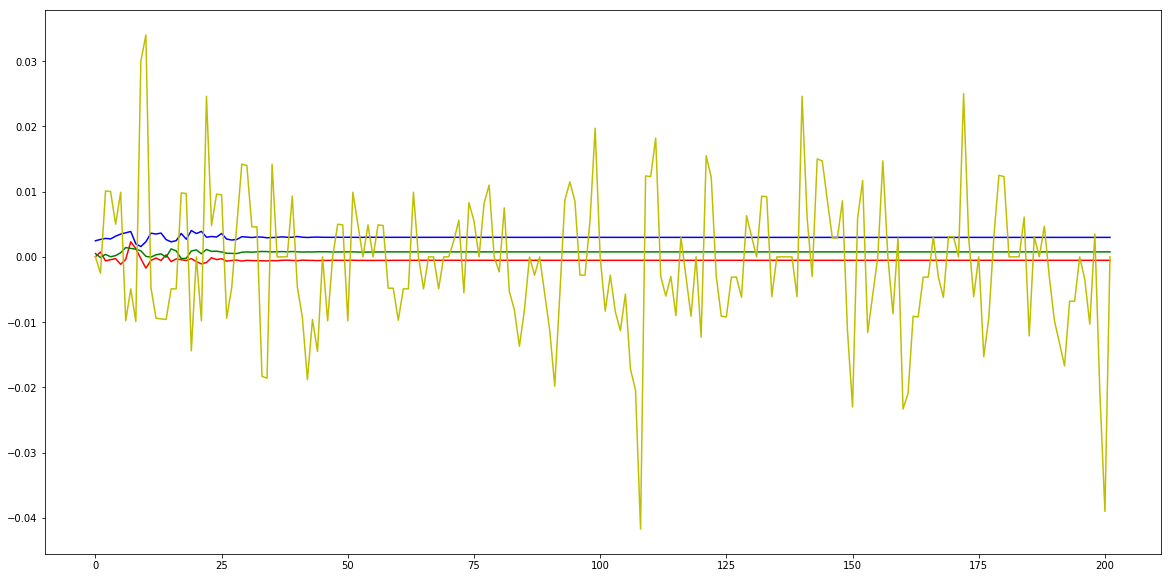

INTUCH


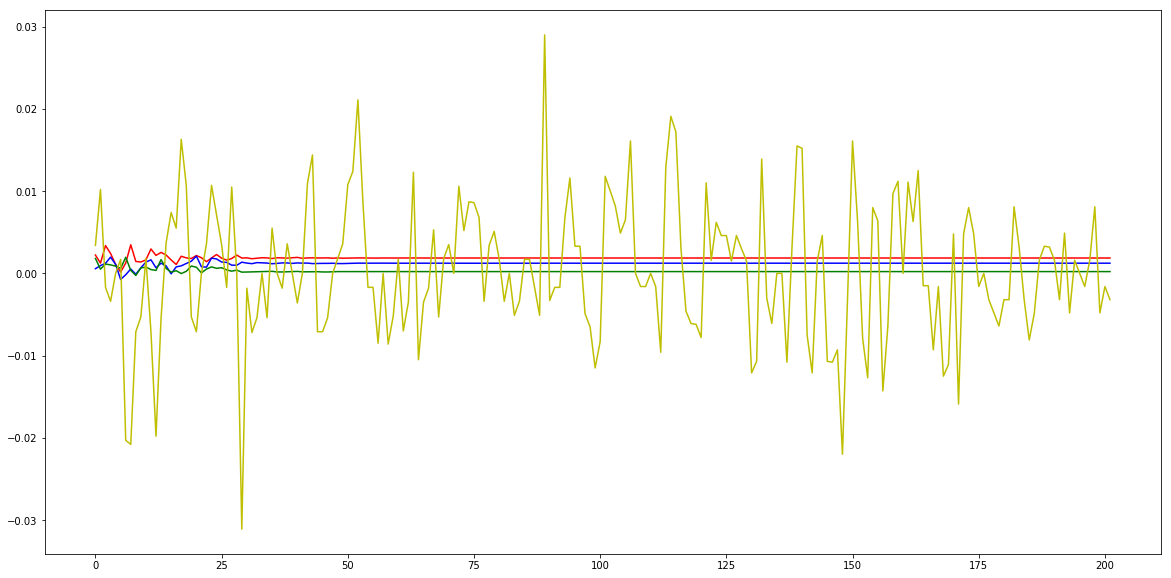

IRPC


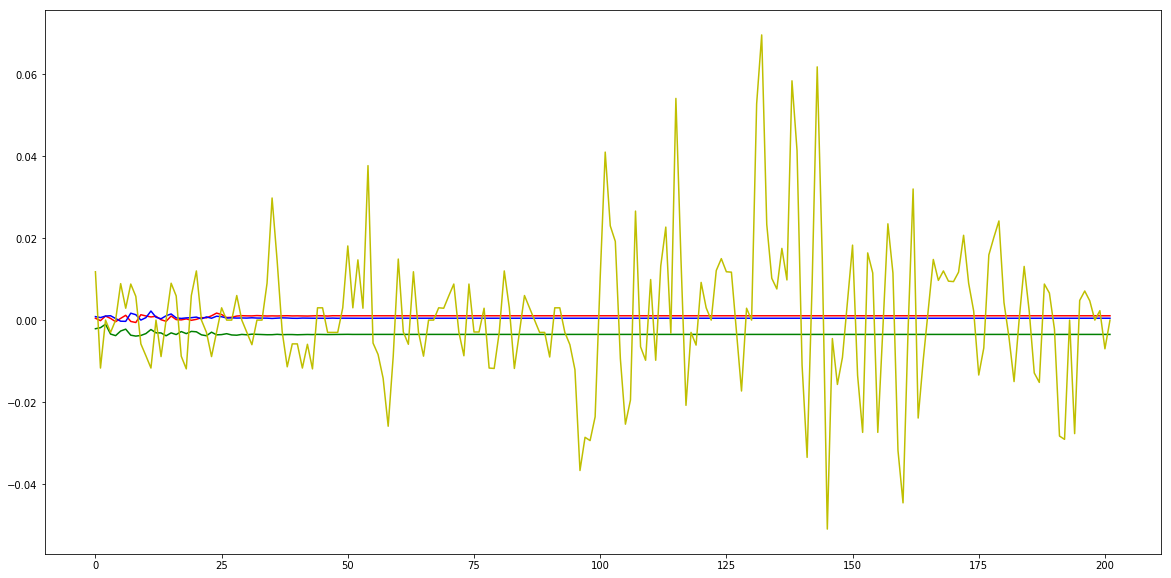

KBANK


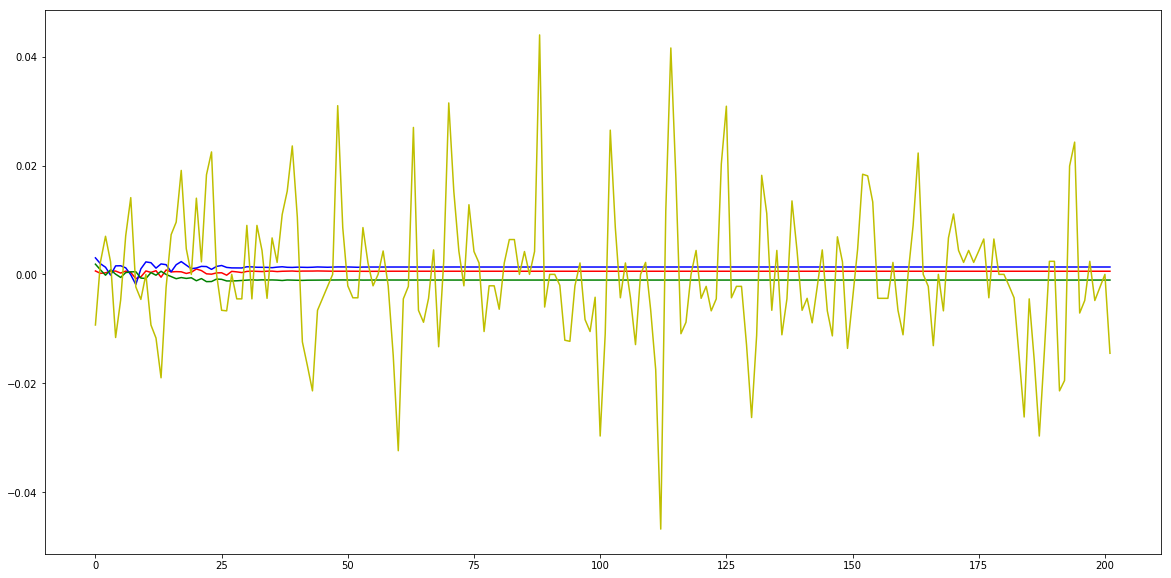

KCE


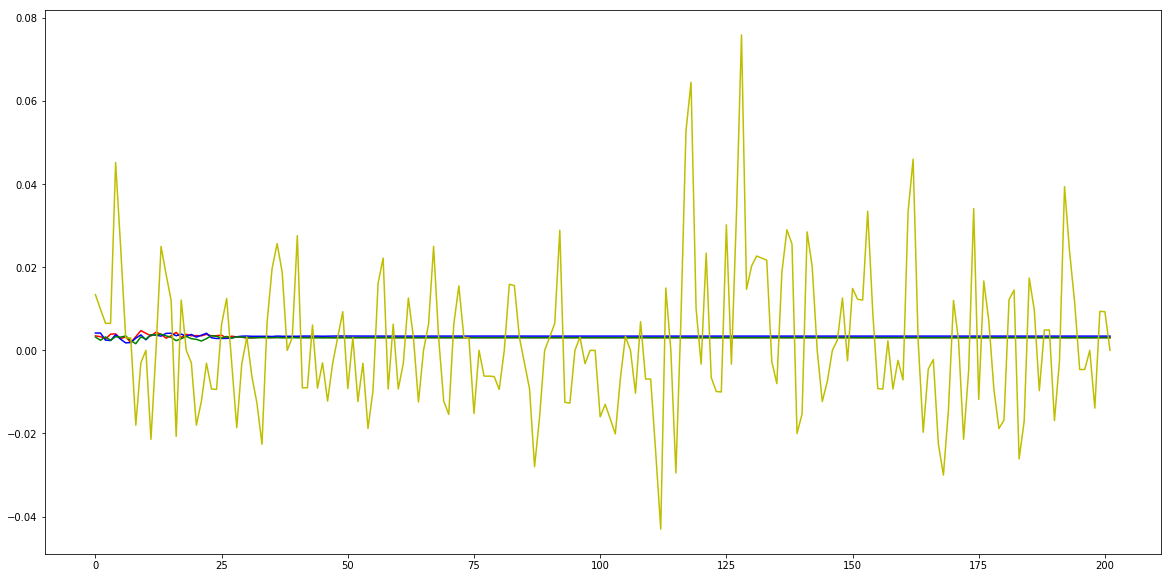

KKP


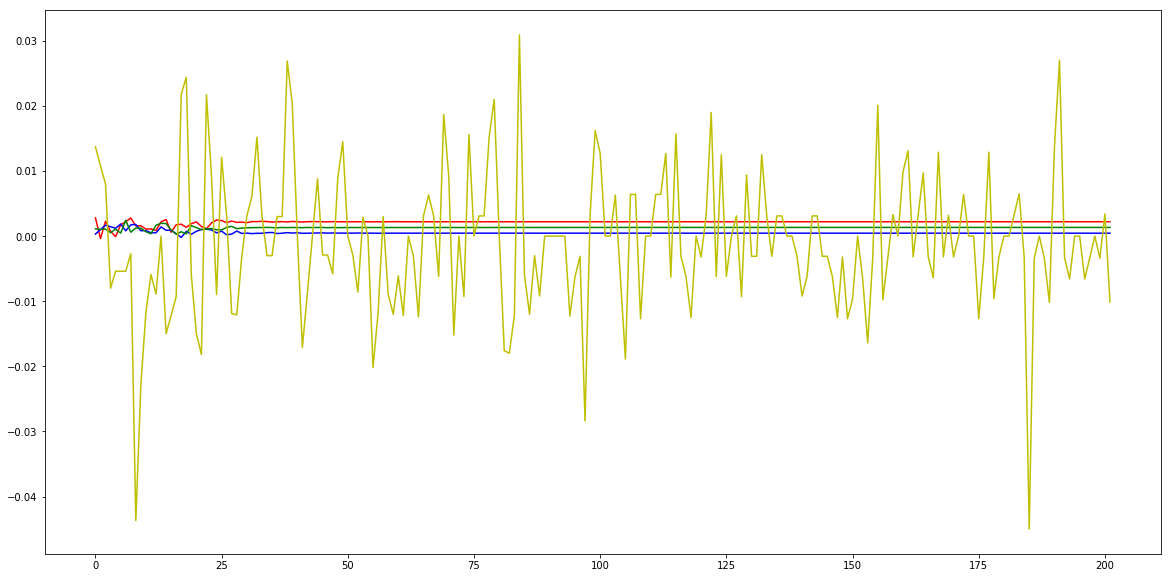

KTB


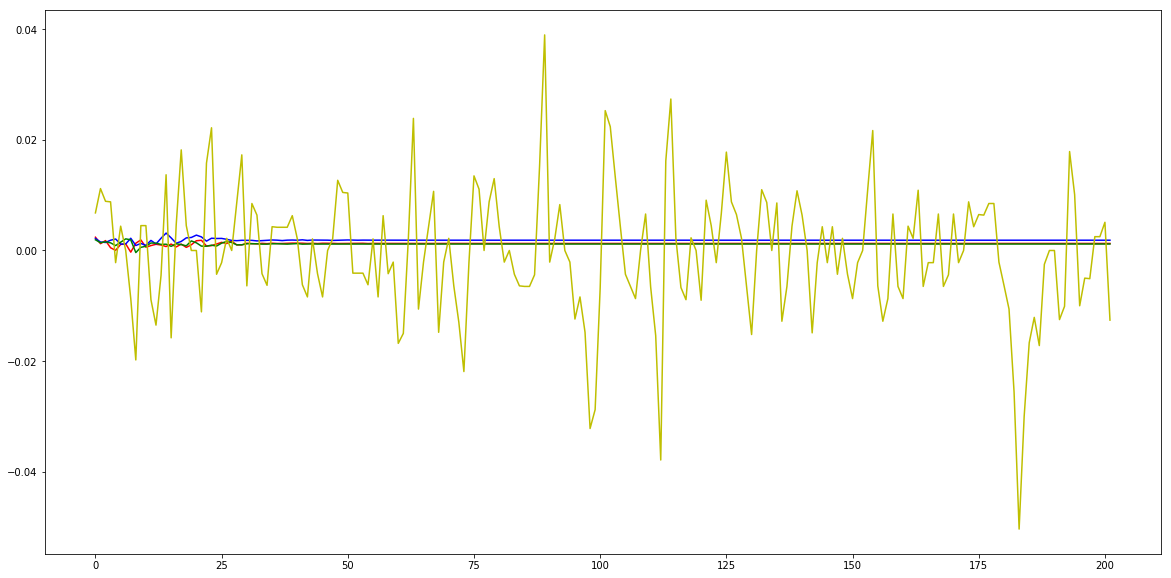

LH


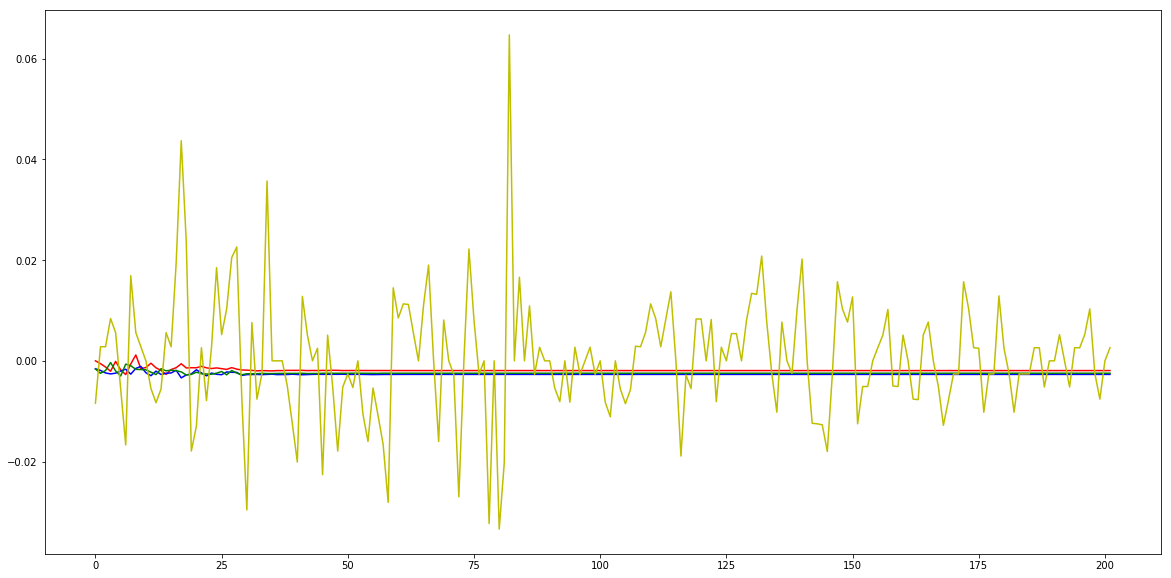

MINT


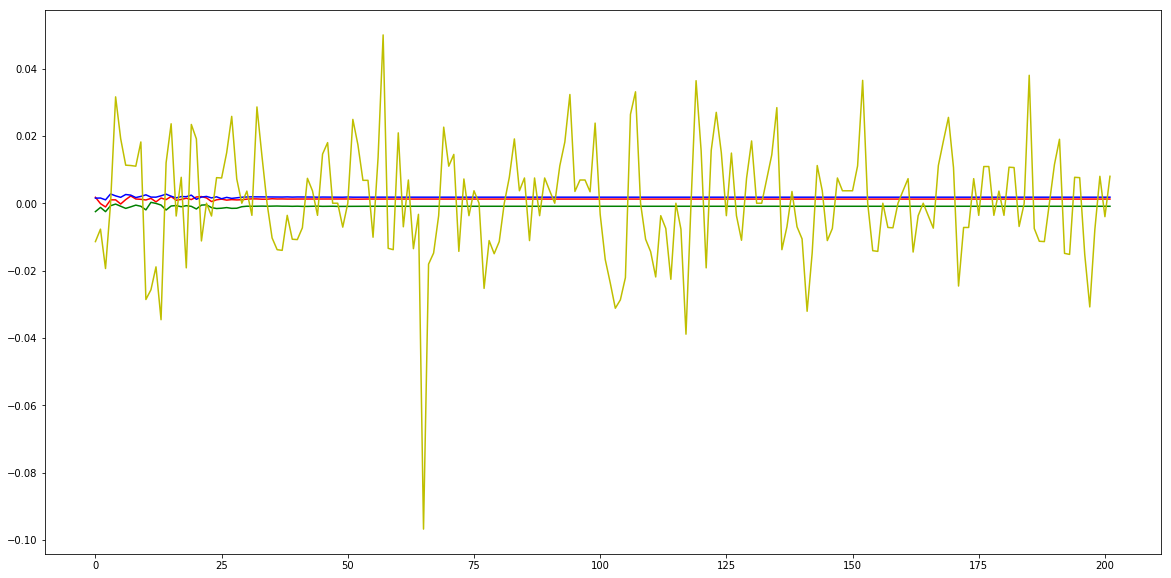

PTT


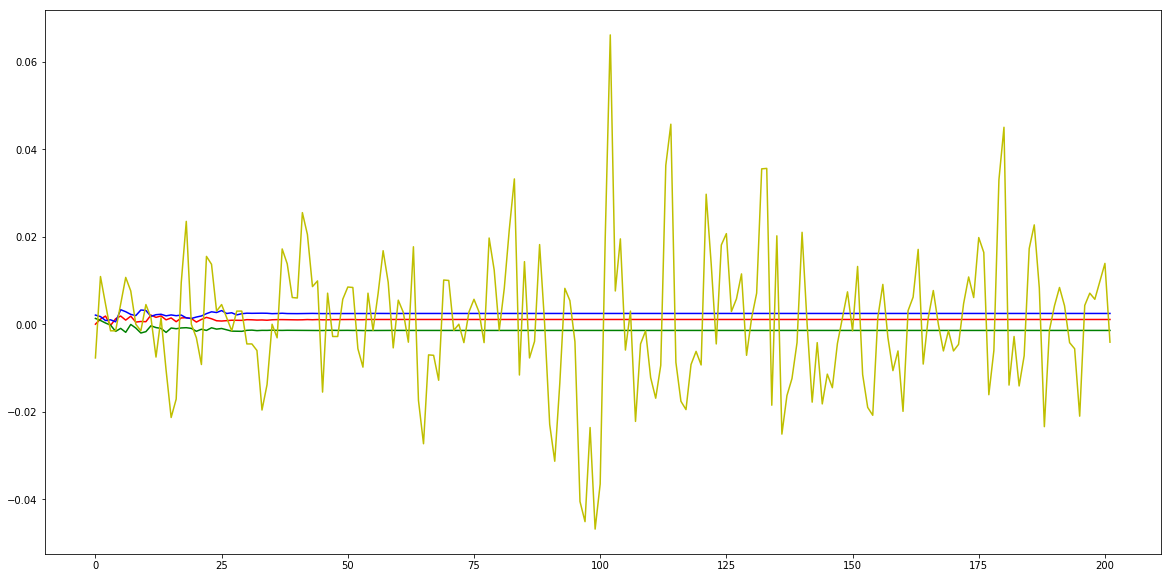

PTTEP


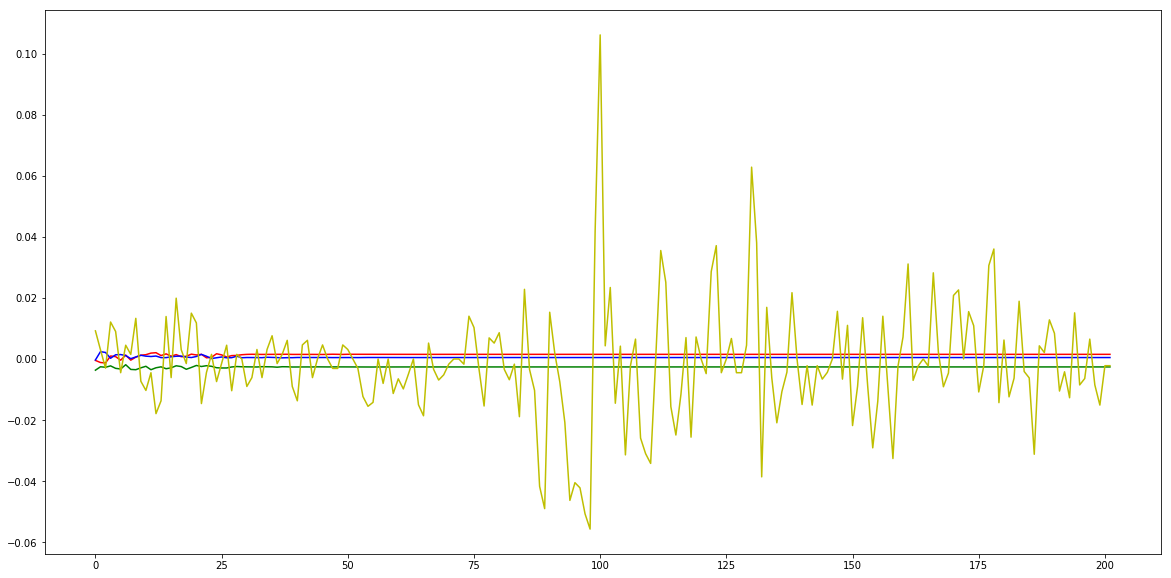

ROBINS


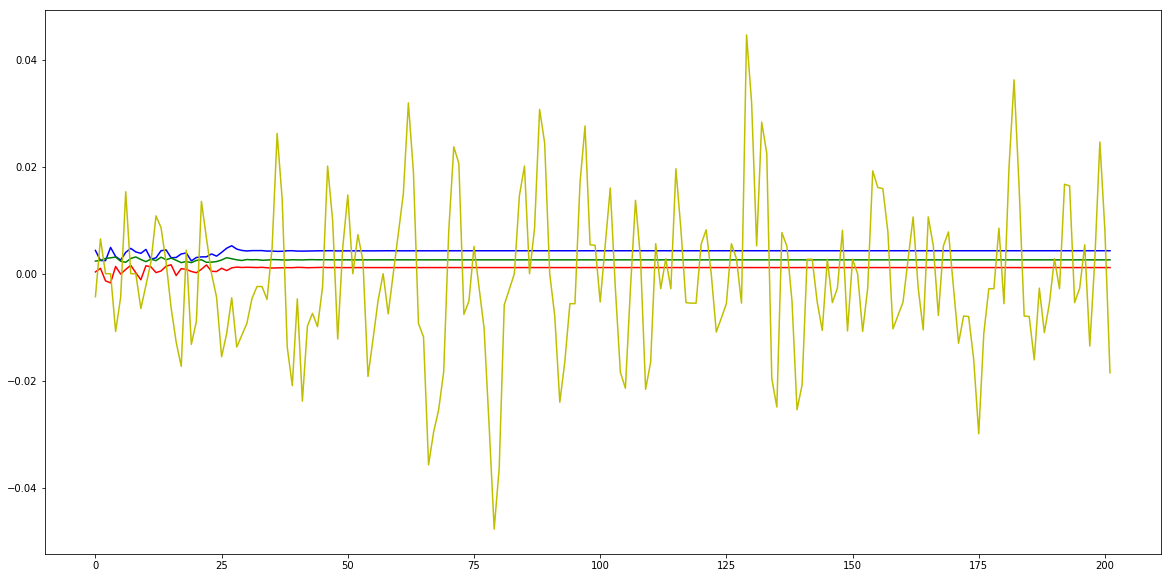

SCB


SCC


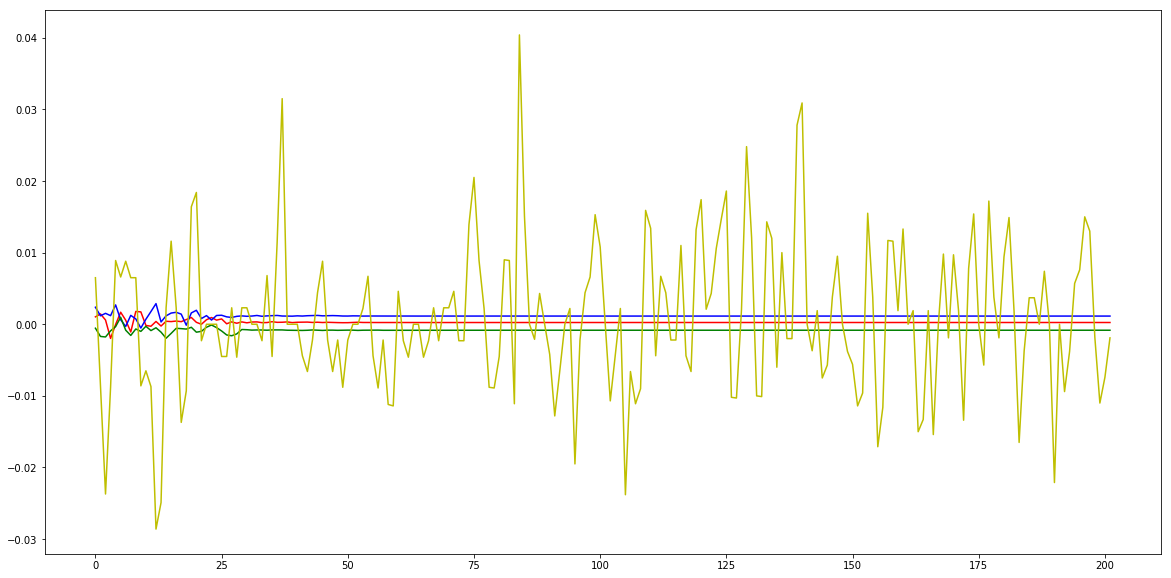

TCAP


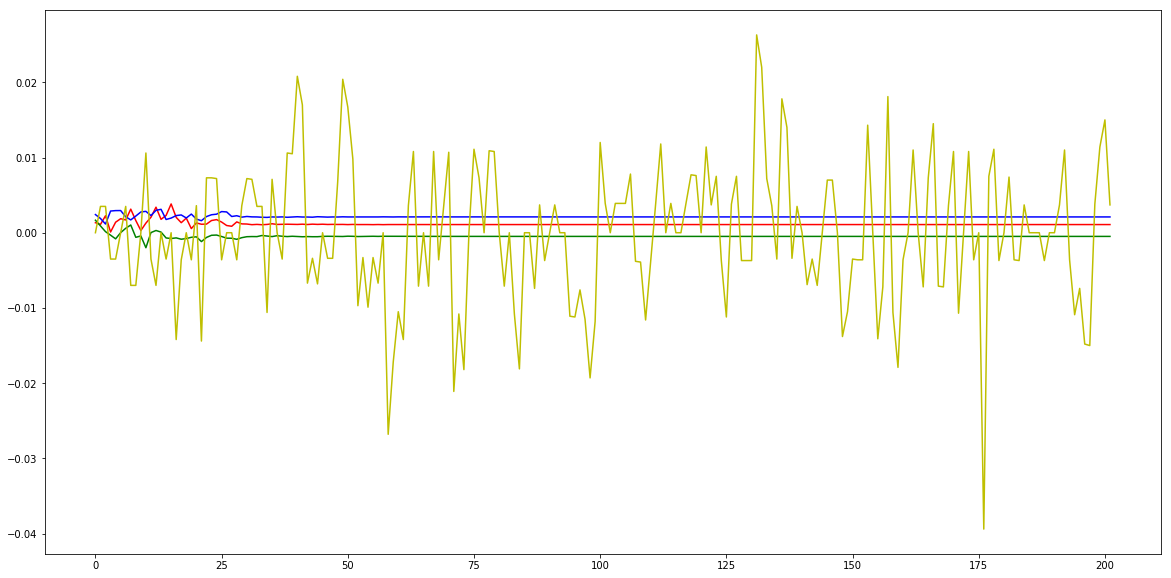

TISCO


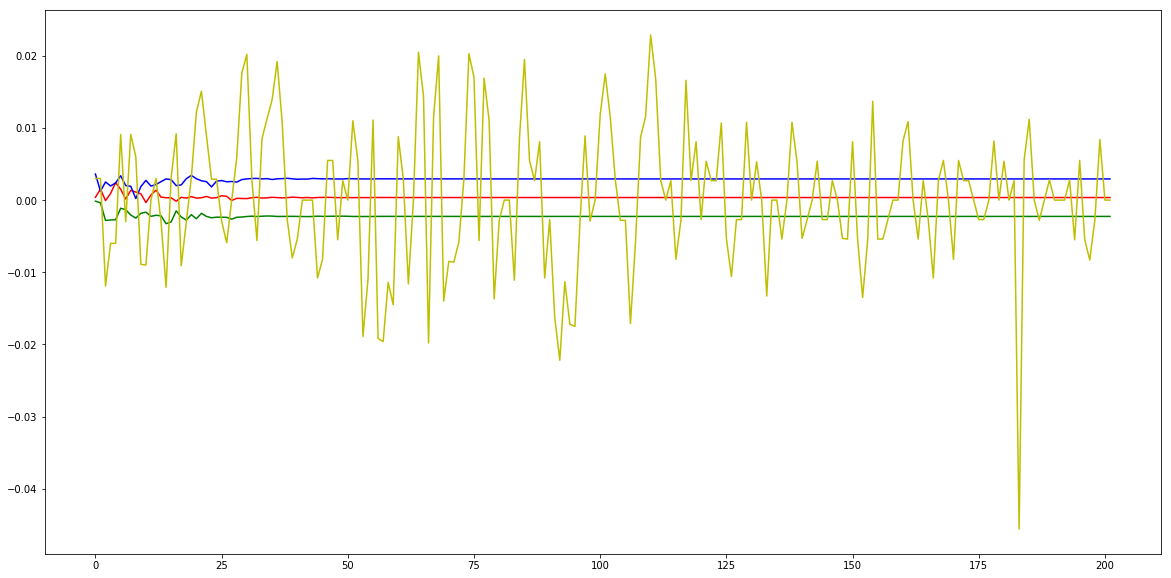

TMB


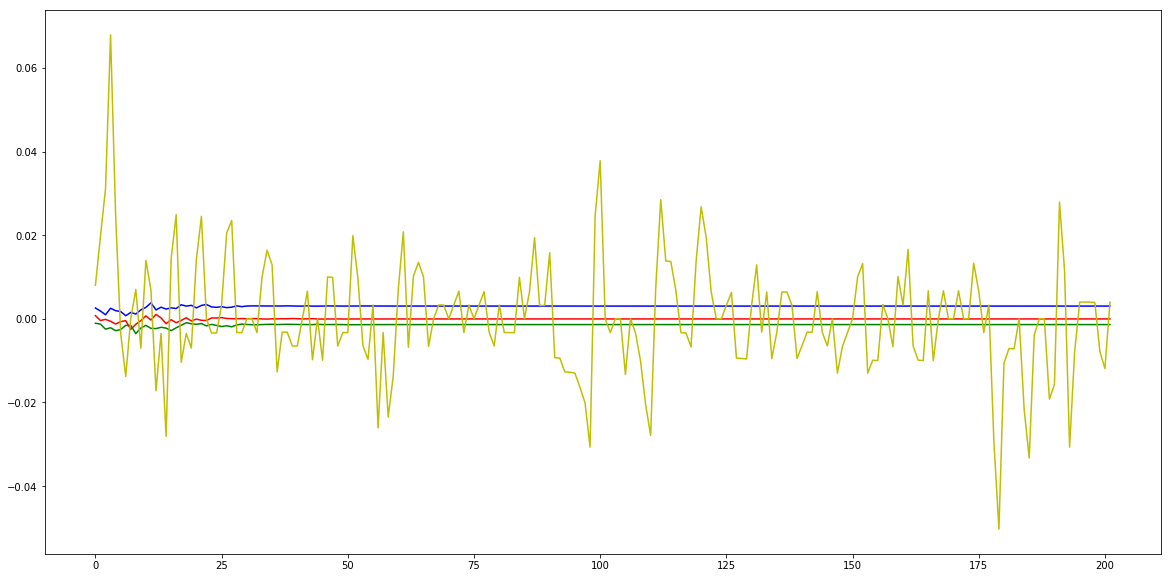

TOP


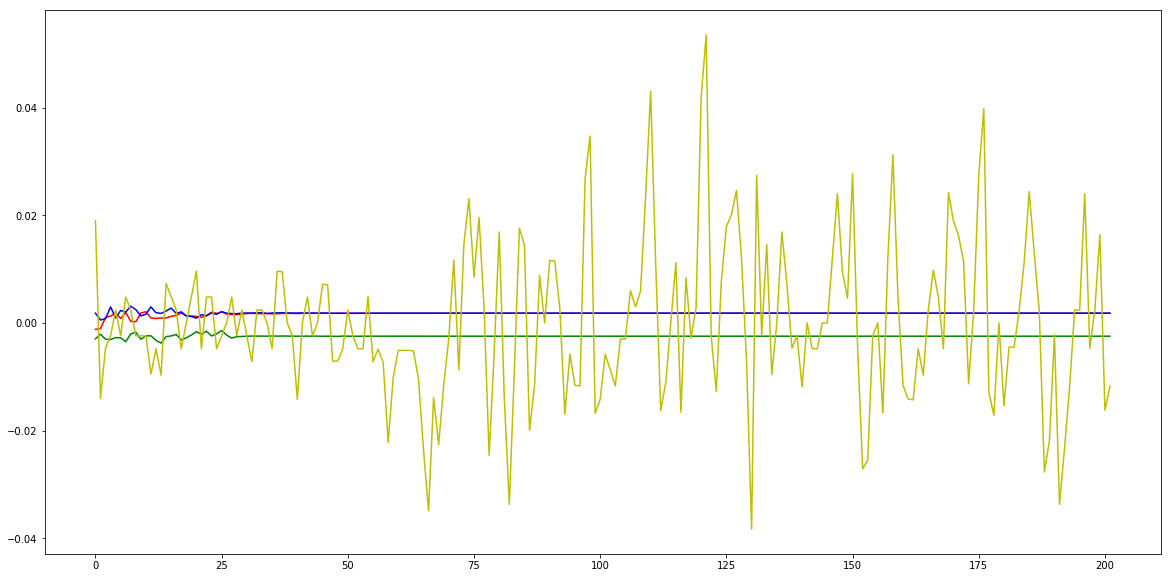

TRUE


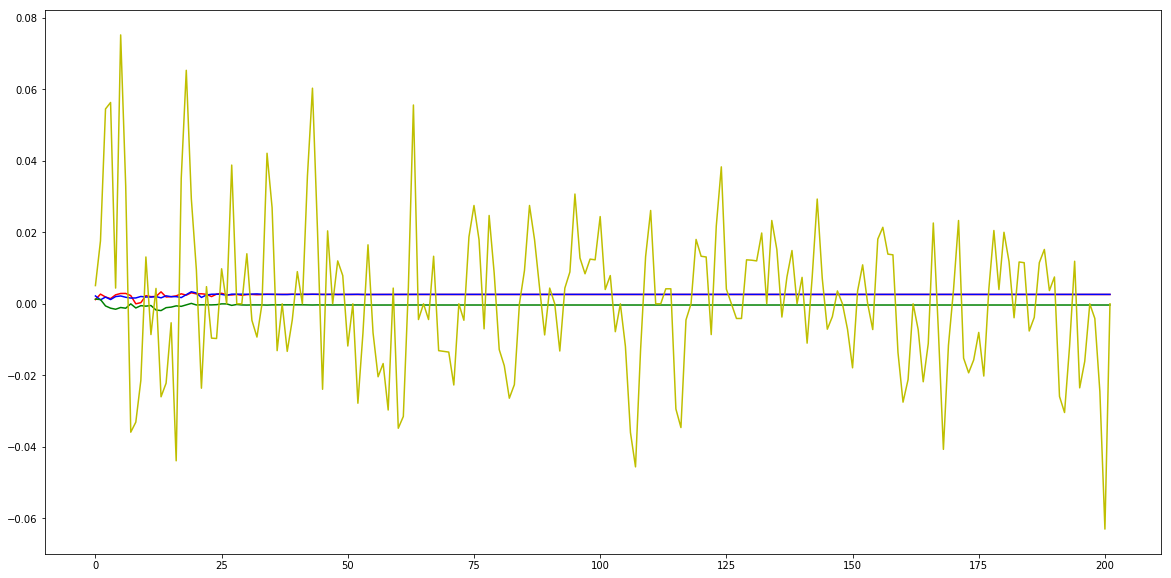

TU


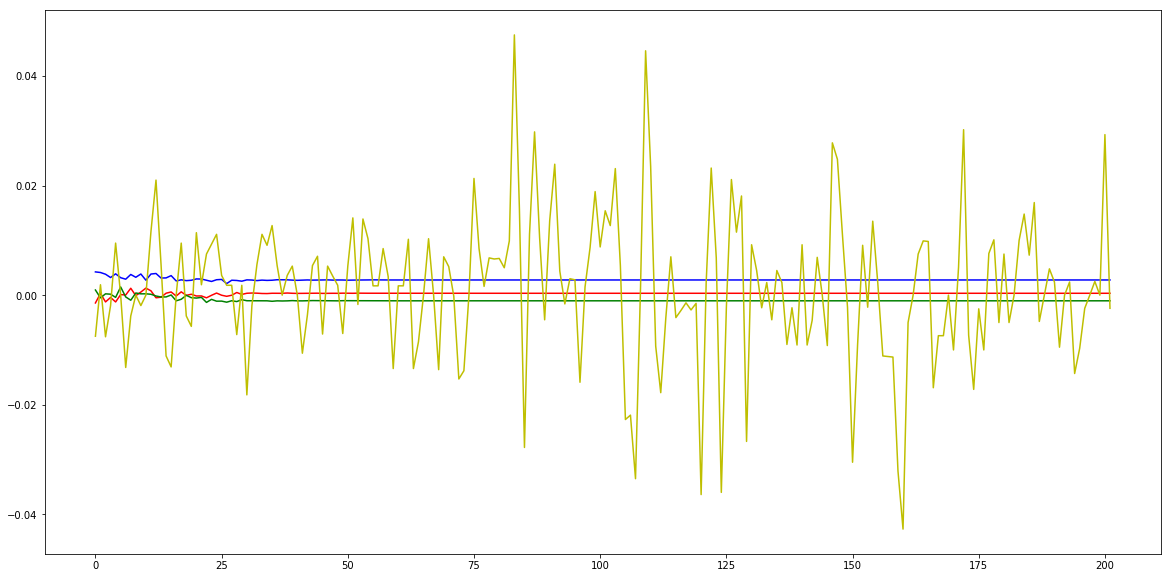

In [16]:
c = 0
for i in range(len(SET50)):
    print(SET50[i])
    data1 = get_data_from_nparray(predicts[c], i)
    data2 = get_data_from_nparray(predicts[c + 1], i)
    data3 = get_data_from_nparray(predicts[c + 2], i)
    data4 = get_data_from_nparray(y_test, i)
    plot_graph(data1, data2, data3, data4)

In [ ]:
# mse, 100 epochs, 1711 training sets, 0.95 learning rate, 0.000001 decay
# first cnn => 64 7, 1: else 32 3, 1
# fully connected => 256 last fc => 37
#0 1 CNN 1 FLC => loss: 6.7711e-04 - acc: 0.0514 - mean_absolute_error: 0.0137
#1 1 CNN 2 FLC => loss: 6.9330e-04 - acc: 0.0508 - mean_absolute_error: 0.0138
#2 1 CNN 3 FLC => loss: 7.1381e-04 - acc: 0.0608 - mean_absolute_error: 0.0138
#3 1 CNN 4 FLC => loss: 7.2392e-04 - acc: 0.0573 - mean_absolute_error: 0.0138
#4 1 CNN 5 FLC => loss: 7.4355e-04 - acc: 0.0514 - mean_absolute_error: 0.0137
#5 2 CNN 1 FLC => loss: 7.4868e-04 - acc: 0.0427 - mean_absolute_error: 0.0139
#6 2 CNN 2 FLC => loss: 7.4134e-04 - acc: 0.0380 - mean_absolute_error: 0.0139
#7 2 CNN 3 FLC => loss: 7.4478e-04 - acc: 0.0444 - mean_absolute_error: 0.0138
#8 2 CNN 4 FLC => loss: 7.5027e-04 - acc: 0.0438 - mean_absolute_error: 0.0137
#9 2 CNN 5 FLC => loss: 7.5178e-04 - acc: 0.0438 - mean_absolute_error: 0.0137
#10 3 CNN 1 FLC => loss: 7.6641e-04 - acc: 0.0427 - mean_absolute_error: 0.0137
#11 3 CNN 2 FLC => loss: 7.6063e-04 - acc: 0.0485 - mean_absolute_error: 0.0138
#12 3 CNN 3 FLC => loss: 7.5434e-04 - acc: 0.0386 - mean_absolute_error: 0.0138
#13 3 CNN 4 FLC => loss: 7.5821e-04 - acc: 0.0415 - mean_absolute_error: 0.0138
#14 3 CNN 5 FLC => loss: 7.5930e-04 - acc: 0.0432 - mean_absolute_error: 0.0137

In [ ]:
# mse, 100 epochs, 1711 training sets, 0.95 learning rate, 0.000001 decay
# first cnn => 128 7, 1: else 64 3, 1
# fully connected => 256 last fc => 37
#0 1 CNN 1 FLC => loss: 6.6658e-04 - acc: 0.0538 - mean_absolute_error: 0.0137
#1 1 CNN 2 FLC => loss: 6.9445e-04 - acc: 0.0584 - mean_absolute_error: 0.0138
#2 1 CNN 3 FLC => loss: 7.0478e-04 - acc: 0.0462 - mean_absolute_error: 0.0137
#3 1 CNN 4 FLC => loss: 7.2177e-04 - acc: 0.0462 - mean_absolute_error: 0.0137
#4 1 CNN 5 FLC => loss: 7.3333e-04 - acc: 0.0555 - mean_absolute_error: 0.0137
#5 2 CNN 1 FLC => loss: 7.3237e-04 - acc: 0.0473 - mean_absolute_error: 0.0139
#6 2 CNN 2 FLC => loss: 7.4139e-04 - acc: 0.0468 - mean_absolute_error: 0.0138
#7 2 CNN 3 FLC => loss: 7.4880e-04 - acc: 0.0421 - mean_absolute_error: 0.0137
#8 2 CNN 4 FLC => loss: 7.5073e-04 - acc: 0.0497 - mean_absolute_error: 0.0137
#9 2 CNN 5 FLC => loss: 7.4863e-04 - acc: 0.0392 - mean_absolute_error: 0.0137
#10 3 CNN 1 FLC => loss: 7.5849e-04 - acc: 0.0468 - mean_absolute_error: 0.0138
#11 3 CNN 2 FLC => loss: 7.5688e-04 - acc: 0.0380 - mean_absolute_error: 0.0138
#12 3 CNN 3 FLC => loss: 7.5373e-04 - acc: 0.0438 - mean_absolute_error: 0.0138
#13 3 CNN 4 FLC => loss: 7.5733e-04 - acc: 0.0444 - mean_absolute_error: 0.0137
#14 3 CNN 5 FLC => loss: 7.5779e-04 - acc: 0.0397 - mean_absolute_error: 0.0137

In [14]:
# mse, 100 epochs, 1711 training sets, 0.95 learning rate, 0.000001 decay
# first cnn => 256 7, 1: else 128 3, 1
# fully connected => 256 last fc => 37
#0 1 CNN 1 FLC => loss: 6.5766e-04 - acc: 0.0584 - mean_absolute_error: 0.0136
#1 1 CNN 2 FLC => loss: 6.6393e-04 - acc: 0.0672 - mean_absolute_error: 0.0137
#2 1 CNN 3 FLC => loss: 7.0242e-04 - acc: 0.0462 - mean_absolute_error: 0.0137
#3 1 CNN 4 FLC => loss: 7.2040e-04 - acc: 0.0497 - mean_absolute_error: 0.0137
#4 1 CNN 5 FLC => loss: 7.3493e-04 - acc: 0.0421 - mean_absolute_error: 0.0137
#5 2 CNN 1 FLC => loss: 7.1968e-04 - acc: 0.0508 - mean_absolute_error: 0.0138
#6 2 CNN 2 FLC => loss: 7.3469e-04 - acc: 0.0462 - mean_absolute_error: 0.0138
#7 2 CNN 3 FLC => loss: 7.4095e-04 - acc: 0.0450 - mean_absolute_error: 0.0138
#8 2 CNN 4 FLC => loss: 7.4369e-04 - acc: 0.0520 - mean_absolute_error: 0.0138
#9 2 CNN 5 FLC => loss: 7.5428e-04 - acc: 0.0456 - mean_absolute_error: 0.0137
#10 3 CNN 1 FLC => loss: 7.5402e-04 - acc: 0.0503 - mean_absolute_error: 0.0138
#11 3 CNN 2 FLC => loss: 7.5059e-04 - acc: 0.0450 - mean_absolute_error: 0.0138
#12 3 CNN 3 FLC => loss: 7.5207e-04 - acc: 0.0456 - mean_absolute_error: 0.0137
#13 3 CNN 4 FLC => loss: 7.5179e-04 - acc: 0.0432 - mean_absolute_error: 0.0137
#14 3 CNN 5 FLC => loss: 7.5515e-04 - acc: 0.0462 - mean_absolute_error: 0.0137